# Modeling Influenza A PR8 (H1N1) in the lungs of mice

This notebook plots the results of parameter optimization using a classical estimation approach and our Integrative Parameter Estimation (IPE) approach.

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True

import seaborn as sns

In [2]:
palette = sns.color_palette('viridis', n_colors=8)
palette

[(0.281412, 0.155834, 0.469201),
 (0.244972, 0.287675, 0.53726),
 (0.190631, 0.407061, 0.556089),
 (0.147607, 0.511733, 0.557049),
 (0.119699, 0.61849, 0.536347),
 (0.20803, 0.718701, 0.472873),
 (0.430983, 0.808473, 0.346476),
 (0.709898, 0.868751, 0.169257)]

In [3]:
palette2 = sns.color_palette('rocket', n_colors=3)
palette2

[(0.38092887, 0.12061482, 0.32506528),
 (0.7965014, 0.10506637, 0.31063031),
 (0.95922872, 0.53307513, 0.3748895)]

In [4]:
palette3 = sns.color_palette('deep', n_colors=8)
palette3

[(0.2980392156862745, 0.4470588235294118, 0.6901960784313725),
 (0.8666666666666667, 0.5176470588235295, 0.3215686274509804),
 (0.3333333333333333, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.3058823529411765, 0.3215686274509804),
 (0.5058823529411764, 0.4470588235294118, 0.7019607843137254),
 (0.5764705882352941, 0.47058823529411764, 0.3764705882352941),
 (0.8549019607843137, 0.5450980392156862, 0.7647058823529411),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373)]

## Lung Target Cell Model
Define the target cell model with T cell compartment

\begin{align}
\dot U &= - \beta U V \\
\dot I &= \beta U V - \delta_I T I \\
\dot V &= p I - c V \\
\dot T &= \delta_T T_0 + r T V - \delta_T T
\end{align}

In [5]:
def lungModel(Y, t, bet, del_I, p, c, r, del_T, T0):
    U, I, V, T = Y
    
    U = max(0,U)
    I = max(0,I)
    V = max(0,V)
    T = max(0,T)

    dU = -bet*U*V
    dI = bet*U*V - del_I*T*I
    dV = p*I - c*V
    dT = r*T*V + del_T*(T0 - T)
    
    return [dU, dI, dV, dT]

In [6]:
parNames=['$V_0$', '$\\beta$', '$\\delta_I$', '$p$', '$c$', '$r$', '$\\delta_T$', 'RSS']

Run all parameter set simulations

In [7]:
def simulations(dfParams, Y0, t, simNum):
    U = []
    I = []
    V = []
    T = []

    U0, I0, V0, T0 = Y0
    
    # V0 = 50
    c = 2.9
    del_T = 0.011
    
    for i in range(simNum):
        bet = dfParams['$\\beta$'][i]
        del_I = dfParams['$\\delta_I$'][i]
        p = dfParams['$p$'][i]
        r = dfParams['$r$'][i]
    
        sol = odeint(lungModel, Y0, t, args=(bet, del_I, p, c, r, del_T, T0))
        U.append(sol[:,0])
        I.append(sol[:,1])
        V.append(sol[:,2])
        T.append(sol[:,3])

    return [U, I, V, T]

## Dynamics using the estimated parameters and bootstraping

In [8]:
dfViralData = pd.read_csv('influenza/viralLoad.csv')
dfViralData.head(4)

,Days,Virus
0,2,448592.338
1,2,1126813.007
2,2,4262158.829
3,2,1126813.007


In [9]:
df_Toapanta = pd.read_csv("influenza/Toapanta_CD8.csv")
df_Eriksson = pd.read_csv("influenza/Eriksson_CD8.csv")
df_McGill = pd.DataFrame({
    'Days': [2, 4, 6, 8, 10],
    'CD8': [86456, 634004, 4899134, 8818444, 8530259]
})
df_VanLeuven = pd.read_csv("influenza/Van_Leuven_CD8.csv")

In [10]:
def apply_exponent(value):
    return 10 ** value

### Quantitative Viral Load

In [11]:
dfParams_log = pd.read_csv('influenza/bestPars_quant_fix.dat', sep=' ', names=parNames)

In [12]:
dfParams = dfParams_log.apply(lambda x: apply_exponent(x) if x.name != 'RSS' else x)

In [13]:
dfParams.head()

,$V_0$,$\beta$,$\delta_I$,$p$,$c$,$r$,$\delta_T$,RSS
0,50.003453,1.909414e-05,1.000000e-08,0.311387,2.900013,1.468250e-06,0.011,6.2676
1,50.003453,1.047129e-05,9.264031e-08,0.467412,2.900013,8.493760e-07,0.011,9.9461
2,50.003453,1.347411e-05,1.118922e-07,0.393641,2.900013,9.536741e-07,0.011,5.6049
3,50.003453,2.127159e-06,1.853105e-06,2.588213,2.900013,1.000000e-08,0.011,12.5240
4,50.003453,8.568405e-07,1.498649e-06,7.350214,2.900013,1.000000e-08,0.011,5.6863


In [14]:
dfParam_describe_qt = dfParams.drop(['$V_0$', '$c$', '$\\delta_T$', 'RSS'], axis=1)
dfParam_describe_qt.describe()

,$\beta$,$\delta_I$,$p$,$r$
count,1.000000e+03,1.000000e+03,1000.000000,1.000000e+03
mean,1.573778e-05,1.039873e-06,1.645948,3.576588e-07
std,2.820879e-05,6.806176e-07,1.173283,5.639863e-07
min,5.317408e-07,1.000000e-08,0.147979,1.000000e-08
25%,2.542144e-06,1.360508e-07,0.551350,1.000000e-08
50%,3.869015e-06,1.465548e-06,1.560271,1.000000e-08
75%,1.117463e-05,1.555607e-06,2.330908,6.682321e-07
max,1.000000e-04,1.896269e-06,8.910457,2.889349e-06


In [15]:
U0 = 1e7
I0 = 0
V0 = 50
T0 = 1e6
Y0 = [U0, I0, V0, T0]

t = np.linspace(0, 25, 561)

simNumber = dfParams.shape[0]

U_Qt, I_Qt, V_Qt, T_Qt = simulations(dfParams, Y0, t, simNumber)

In [16]:
# Convert list of arrays to a 2D numpy array and compute median and confidence innterval
VQt_2D = np.array(V_Qt)
TQt_2D = np.array(T_Qt)
median_VQt = np.median(VQt_2D, axis=0)
confidence_VQt = np.percentile(VQt_2D, [2.5, 97.5], axis=0)
median_TQt = np.median(TQt_2D, axis=0)
confidence_TQt = np.percentile(TQt_2D, [2.5, 97.5], axis=0)
# mean_VQt = np.mean(VQt_2D, axis=0)
# std_VQt = np.std(VQt_2D, axis=0)

In [17]:
dfParams_quant = dfParams.drop(columns=['$V_0$', '$c$', '$\\delta_T$', 'RSS']).melt(var_name='Parameters', value_name='Values')

### Quantitative T cell

In [18]:
dfParams_log = pd.read_csv('influenza/bestPars_quant_fix_T.dat', sep=' ', names=parNames)

In [19]:
dfParams = dfParams_log.apply(lambda x: apply_exponent(x) if x.name != 'RSS' else x)

In [20]:
dfParams.tail(4)

,$V_0$,$\beta$,$\delta_I$,$p$,$c$,$r$,$\delta_T$,RSS
996,50.003453,0.000003,0.000001,1.735801,2.900013,1.000000e-08,0.011,118.590
997,50.003453,0.000005,0.000001,1.311596,2.900013,2.779073e-08,0.011,82.168
998,50.003453,0.000002,0.000001,2.949171,2.900013,5.361669e-08,0.011,78.192
999,50.003453,0.000002,0.000002,3.187866,2.900013,1.000000e-08,0.011,69.998


In [21]:
dfParam_describe_qt_T = dfParams.drop(['$V_0$', '$c$', '$\\delta_T$', 'RSS'], axis=1)
dfParam_describe_qt_T.describe()

,$\beta$,$\delta_I$,$p$,$r$
count,1.000000e+03,1.000000e+03,1000.000000,1.000000e+03
mean,3.522259e-06,1.200250e-06,1.865908,6.850510e-08
std,1.355443e-06,2.040190e-07,0.825738,4.756020e-08
min,8.344494e-07,5.959365e-07,0.614045,1.000000e-08
25%,2.491581e-06,1.045322e-06,1.286619,3.216993e-08
50%,3.317798e-06,1.192752e-06,1.674557,6.056906e-08
75%,4.327878e-06,1.349351e-06,2.255407,9.608376e-08
max,9.099133e-06,1.787310e-06,6.835968,2.887354e-07


In [22]:
U0 = 1e7
I0 = 0
V0 = 50
T0 = 1e6
Y0 = [U0, I0, V0, T0]

t = np.linspace(0, 25, 561)

simNumber = dfParams.shape[0]

U_Qt_T, I_Qt_T, V_Qt_T, T_Qt_T = simulations(dfParams, Y0, t, simNumber)

In [23]:
# Convert list of arrays to a 2D numpy array and compute median and confidence innterval
VQt_T_2D = np.array(V_Qt_T)
TQt_T_2D = np.array(T_Qt_T)
median_VQt_T = np.median(VQt_T_2D, axis=0)
confidence_VQt_T = np.percentile(VQt_T_2D, [2.5, 97.5], axis=0)
median_TQt_T = np.median(TQt_T_2D, axis=0)
confidence_TQt_T = np.percentile(TQt_T_2D, [2.5, 97.5], axis=0)
# mean_VQt_T = np.mean(VQt_T_2D, axis=0)
# std_VQt_T = np.std(VQt_T_2D, axis=0)

In [24]:
dfParams_quant_T = dfParams.drop(columns=['$V_0$', '$c$', '$\\delta_T$', 'RSS']).melt(var_name='Parameters', value_name='Values')

### Qualitative T cell level

In [25]:
dfTcellQual = pd.read_csv('influenza/qualTcell.csv')

Tmax = 1e7
T0 = 1e6
dfTcellQual['Tmin'] = dfTcellQual['Tmin']*(Tmax-T0) + T0
dfTcellQual['Tmax'] = dfTcellQual['Tmax']*(Tmax-T0) + T0

In [26]:
dfTcellQual

,tmin,tmax,Tmin,Tmax
0,0.0,5.5,1000000.0,2799982.0
1,5.5,13.5,4761073.0,7468327.0
2,13.5,21.5,2799982.0,4761073.0


In [27]:
dfParams_log = pd.read_csv('influenza/bestPars_qual_fix.dat', sep=' ', names=parNames)
# dfParams_log = pd.read_csv('influenza/bestPars_qual_newWin.dat', sep=' ', names=parNames)

In [28]:
dfParams = dfParams_log.apply(lambda x: apply_exponent(x) if x.name != 'RSS' else x)
# dfParams = dfParams.iloc[(dfParams['RSS'] != 1.0e+38).values].reset_index()

In [29]:
dfParams.tail(4)

,$V_0$,$\beta$,$\delta_I$,$p$,$c$,$r$,$\delta_T$,RSS
996,50.003453,0.000007,3.571083e-07,0.746449,2.900013,4.468893e-07,0.011,8.5867
997,50.003453,0.000008,3.698282e-07,0.836373,2.900013,4.103931e-07,0.011,11.5250
998,50.003453,0.000004,4.177342e-07,1.041358,2.900013,3.663532e-07,0.011,16.3470
999,50.003453,0.000010,3.293063e-07,0.550174,2.900013,5.663697e-07,0.011,6.4180


In [30]:
dfParam_describe_ql = dfParams.drop(['$V_0$', '$c$', '$\\delta_T$', 'RSS'], axis=1)
dfParam_describe_ql.describe()

,$\beta$,$\delta_I$,$p$,$r$
count,1000.000000,1.000000e+03,1000.000000,1.000000e+03
mean,0.000009,3.409495e-07,0.803928,4.593809e-07
std,0.000008,4.313452e-08,0.305108,1.435112e-07
min,0.000002,2.373012e-07,0.208161,1.535324e-07
25%,0.000006,3.057560e-07,0.589658,3.495023e-07
50%,0.000008,3.481369e-07,0.739691,4.437108e-07
75%,0.000010,3.720703e-07,0.954388,5.410346e-07
max,0.000100,4.479195e-07,2.399385,1.356438e-06


In [31]:
U0 = 1e7
I0 = 0
V0 = 50
T0 = 1e6
Y0 = [U0, I0, V0, T0]

t = np.linspace(0, 25, 561)

simNumber = dfParams.shape[0]

U_Ql, I_Ql, V_Ql, T_Ql = simulations(dfParams, Y0, t, simNumber)

In [32]:
# Convert list of arrays to a 2D numpy array and compute median and confidence innterval
VQl_2D = np.array(V_Ql)
TQl_2D = np.array(T_Ql)
median_VQl = np.median(VQl_2D, axis=0)
confidence_VQl = np.percentile(VQl_2D, [2.5, 97.5], axis=0)
median_TQl = np.median(TQl_2D, axis=0)
confidence_TQl = np.percentile(TQl_2D, [2.5, 97.5], axis=0)
# mean_VQl = np.mean(VQl_2D, axis=0)
# std_VQl = np.std(VQl_2D, axis=0)

In [33]:
dfParams_qual = dfParams.drop(columns=['$V_0$', '$c$', '$\\delta_T$', 'RSS']).melt(var_name='Parameters', value_name='Values')

### Simulation plots

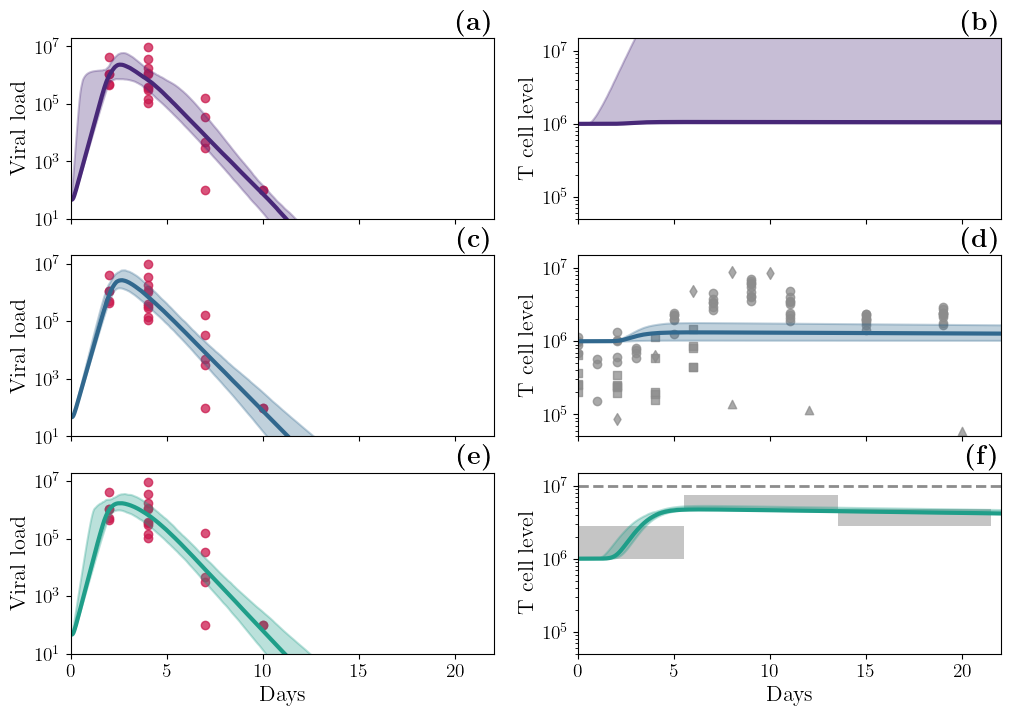

In [34]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(12,8), sharex=True)

# QUANTITATIVE VIRAL LOAD
axs[0,0].scatter(x=dfViralData['Days'], y=dfViralData['Virus'], color=palette2[1], marker="o", alpha=0.75)
axs[0,0].plot(t, median_VQt, lw=3, color=palette[0])
axs[0,0].fill_between(t, confidence_VQt[0], confidence_VQt[1], color=palette[0], alpha=0.3, lw=1.5)
axs[0,0].set_yscale('log')
axs[0,0].set_xlim((0, 22))
axs[0,0].set_ylim((1e1, 2e7))

axs[0,1].plot(t, median_TQt, lw=3, color=palette[0])
axs[0,1].fill_between(t, confidence_TQt[0], confidence_TQt[1], color=palette[0], alpha=0.3, lw=1.5)
axs[0,1].set_yscale('log')
axs[0,1].set_xlim((0, 22))
axs[0,1].set_ylim((0.5e5, 1.5e7))

# QUANTITATIVE T CELL LEVEL

axs[1,0].scatter(x=dfViralData['Days'], y=dfViralData['Virus'], color=palette2[1], marker="o", alpha=0.75)
axs[1,0].plot(t, median_VQt_T, lw=3, color=palette[2])
axs[1,0].fill_between(t, confidence_VQt_T[0], confidence_VQt_T[1], color=palette[2], alpha=0.3, lw=1.5)
axs[1,0].set_yscale('log')
axs[1,0].set_xlim((0, 22))
axs[1,0].set_ylim((1e1, 2e7))

axs[1,1].scatter(df_Toapanta['Days'], df_Toapanta['CD8'],
            color=palette3[7], label='Toapanata et al. (2009)', marker='o', alpha=0.75)
axs[1,1].scatter(df_Eriksson['Days'], df_Eriksson['CD8'],
            color=palette3[7], label='Eriksson et al. (2009)', marker='^', alpha=0.75)
axs[1,1].scatter(df_VanLeuven['Days'], df_VanLeuven['CD8'],
            color=palette3[7], label='Van Leuven et al. (2021)', marker='s', alpha=0.75)
axs[1,1].scatter(df_McGill['Days'], df_McGill['CD8'],
            color=palette3[7], label='McGill et al. (2022)', marker='d', alpha=0.75)
# axs[1,1].scatter(x=dfCD8data['Days'], y=dfCD8data['CD8'], color=palette3[7], marker="^")
axs[1,1].plot(t, median_TQt_T, lw=3, color=palette[2])
axs[1,1].fill_between(t, confidence_TQt_T[0], confidence_TQt_T[1], color=palette[2], alpha=0.3, lw=1.5)
axs[1,1].set_yscale('log')
axs[1,1].set_xlim((0, 22))
axs[1,1].set_ylim((0.5e5, 1.5e7))

# QUALITATIVE T CELL LEVEL

for i in range(len(dfTcellQual['tmin'])):
    tmin = dfTcellQual['tmin'].values[i]
    Tmin = dfTcellQual['Tmin'].values[i]
    width = dfTcellQual['tmax'].values[i] - tmin
    height = dfTcellQual['Tmax'].values[i] - Tmin
    rect = plt.Rectangle((tmin, Tmin), width, height, fc=palette3[7], alpha=0.5)
    axs[2,1].add_patch(rect)

axs[2,0].scatter(x=dfViralData['Days'], y=dfViralData['Virus'], color=palette2[1], marker="o", alpha=0.75)
axs[2,0].plot(t, median_VQl, lw=3, color=palette[4])
axs[2,0].fill_between(t, confidence_VQl[0], confidence_VQl[1], color=palette[4], alpha=0.3, lw=1.5)
# axs[2,0].hlines(y = 5e1, xmin=0, xmax=25, color=palette3[7], lw=2, ls='--')
axs[2,0].set_yscale('log')
axs[2,0].set_xlim((0, 22))
axs[2,0].set_ylim((1e1, 2e7))

axs[2,1].plot(t, median_TQl, lw=3, color=palette[4])
axs[2,1].fill_between(t, confidence_TQl[0], confidence_TQl[1], color=palette[4], alpha=0.3, lw=1.5)
axs[2,1].hlines(y = 1e7, xmin=0, xmax=25, color=palette3[7], lw=2, ls='--')
axs[2,1].set_yscale('log')
axs[2,1].set_xlim((0, 22))
axs[2,1].set_ylim((0.5e5, 1.5e7))

axs[0,0].set_ylabel('Viral load')
axs[0,1].set_ylabel('T cell level')
axs[1,0].set_ylabel('Viral load')
axs[1,1].set_ylabel('T cell level')
axs[2,0].set_ylabel('Viral load')
axs[2,1].set_ylabel('T cell level')

axs[0,0].set_title(r'\textbf{(a)}', loc='right')
axs[0,1].set_title(r'\textbf{(b)}', loc='right')
axs[1,0].set_title(r'\textbf{(c)}', loc='right')
axs[1,1].set_title(r'\textbf{(d)}', loc='right')
axs[2,0].set_title(r'\textbf{(e)}', loc='right')
axs[2,1].set_title(r'\textbf{(f)}', loc='right')

axs[2,0].set_xlabel('Days')
axs[2,1].set_xlabel('Days')

# plt.savefig("influenza_graphs_fix.svg", transparent=True)
# plt.savefig("influenza_graphs.pdf", transparent=True)

plt.show()

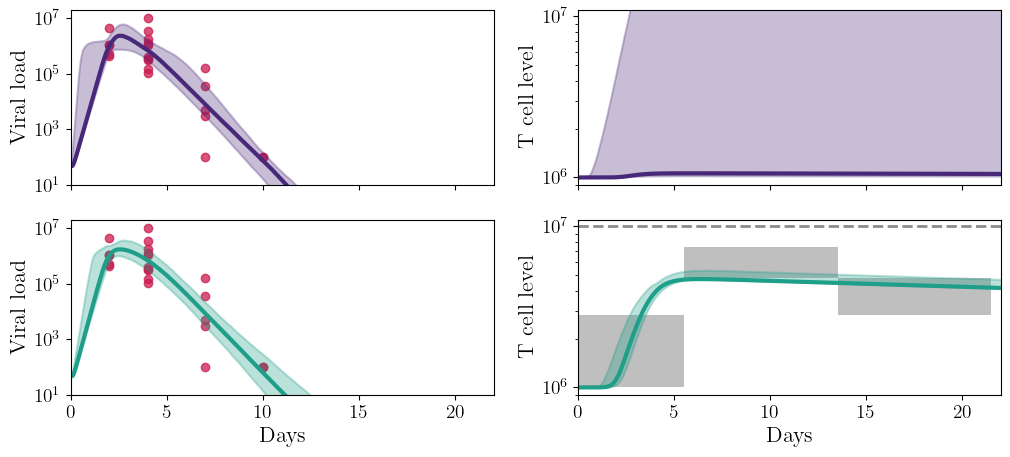

In [35]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,5), sharex=True)

axs[0,0].scatter(x=dfViralData['Days'], y=dfViralData['Virus'], color=palette2[1], marker="o", alpha=0.75)
axs[0,0].plot(t, median_VQt, lw=3, color=palette[0])
axs[0,0].fill_between(t, confidence_VQt[0], confidence_VQt[1], color=palette[0], alpha=0.3, lw=1.5)
axs[0,0].set_yscale('log')
axs[0,0].set_xlim((0, 22))
axs[0,0].set_ylim((1e1, 2e7))

axs[0,1].plot(t, median_TQt, lw=3, color=palette[0])
axs[0,1].fill_between(t, confidence_TQt[0], confidence_TQt[1], color=palette[0], alpha=0.3, lw=1.5)
axs[0,1].set_yscale('log')
axs[0,1].set_xlim((0, 22))
axs[0,1].set_ylim((0.9e6, 1.1e7))

for i in range(len(dfTcellQual['tmin'])):
    tmin = dfTcellQual['tmin'].values[i]
    Tmin = dfTcellQual['Tmin'].values[i]
    width = dfTcellQual['tmax'].values[i] - tmin
    height = dfTcellQual['Tmax'].values[i] - Tmin
    rect = plt.Rectangle((tmin, Tmin), width, height, fc='gray', alpha=0.5)
    axs[1,1].add_patch(rect)

axs[1,0].scatter(x=dfViralData['Days'], y=dfViralData['Virus'], color=palette2[1], marker="o", alpha=0.75)
axs[1,0].plot(t, median_VQl, lw=3, color=palette[4])
axs[1,0].fill_between(t, confidence_VQl[0], confidence_VQl[1], color=palette[4], alpha=0.3, lw=1.5)
# axs[1,0].hlines(y = 5e1, xmin=0, xmax=25, color=palette3[7], lw=2, ls='--')
axs[1,0].set_yscale('log')
axs[1,0].set_xlim((0, 22))
axs[1,0].set_ylim((1e1, 2e7))

axs[1,1].plot(t, median_TQl, lw=3, color=palette[4])
axs[1,1].fill_between(t, confidence_TQl[0], confidence_TQl[1], color=palette[4], alpha=0.3, lw=1.5)
axs[1,1].hlines(y = 1e7, xmin=0, xmax=25, color=palette3[7], lw=2, ls='--')
axs[1,1].set_yscale('log')
axs[1,1].set_xlim((0, 22))
axs[1,1].set_ylim((0.9e6, 1.1e7))

axs[0,0].set_ylabel('Viral load')
axs[0,1].set_ylabel('T cell level')
axs[1,0].set_ylabel('Viral load')
axs[1,1].set_ylabel('T cell level')

axs[1,0].set_xlabel('Days')
axs[1,1].set_xlabel('Days')

# plt.savefig("influenza_graphs_fix.svg", transparent=True)

plt.show()

### Parameter distribution

In [36]:
dfParams_quant['Strategy'] = 'I'
dfParams_quant_T['Strategy'] = 'II'
dfParams_qual['Strategy'] = 'III'
# dfParams_all = pd.concat([dfParams_quant, dfParams_quant_T, dfParams_qual])
dfParams_all = pd.concat([dfParams_quant, dfParams_qual])
# dfParams_all = dfParams_quant.copy()

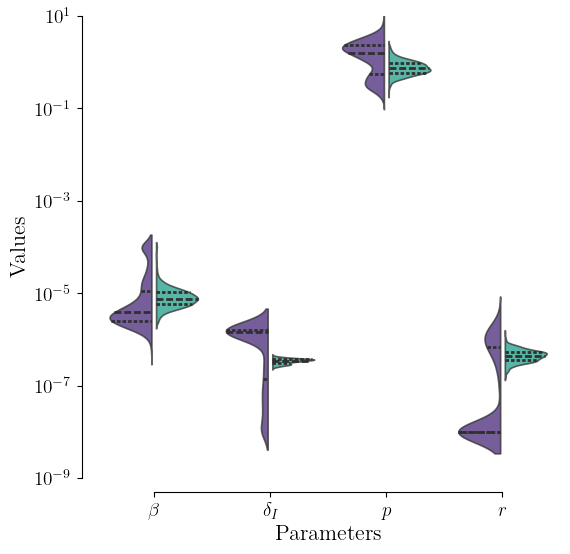

In [37]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6,6), facecolor='white')

colors = [palette[0], palette[4]]

axs = sns.violinplot(data=dfParams_all, x='Parameters', y='Values', hue='Strategy', log_scale=True,
               split=True, palette=colors, alpha=0.75, linewidth=1.2, density_norm="count", gap=0.1,
               inner="quart", saturation=1, inner_kws=dict(linewidth=2))

axs.set_yscale("log")         # Ensure log scale is active
axs.set_ylim(1e-9, 1e1)       # Set y-axis limits

sns.despine(offset=10, trim=True);

plt.legend([],[], frameon=False)

# plt.savefig("influenza_boots_fix.svg", transparent=True)
# plt.savefig("influenza_boots_fix.pdf", transparent=True)

plt.show()

In [38]:
dirPath = 'influenza/profilesData_fix/'

In [39]:
df_bet_qt = pd.read_csv(dirPath+'beta_profile_qt.dat', sep=' ', names=parNames).filter(['$\\beta$', 'RSS'])
df_delI_qt = pd.read_csv(dirPath+'delI_profile_qt.dat', sep=' ', names=parNames).filter(['$\\delta_I$', 'RSS'])
df_p_qt = pd.read_csv(dirPath+'p_profile_qt.dat', sep=' ', names=parNames).filter(['$p$', 'RSS'])
df_r_qt = pd.read_csv(dirPath+'r_profile_qt.dat', sep=' ', names=parNames).filter(['$r$', 'RSS'])

In [40]:
df_bet_ql = pd.read_csv(dirPath+'beta_profile_ql.dat', sep=' ', names=parNames).filter(['$\\beta$', 'RSS'])
df_delI_ql = pd.read_csv(dirPath+'delI_profile_ql.dat', sep=' ', names=parNames).filter(['$\\delta_I$', 'RSS'])
df_p_ql = pd.read_csv(dirPath+'p_profile_ql.dat', sep=' ', names=parNames).filter(['$p$', 'RSS'])
df_r_ql = pd.read_csv(dirPath+'r_profile_ql.dat', sep=' ', names=parNames).filter(['$r$', 'RSS'])

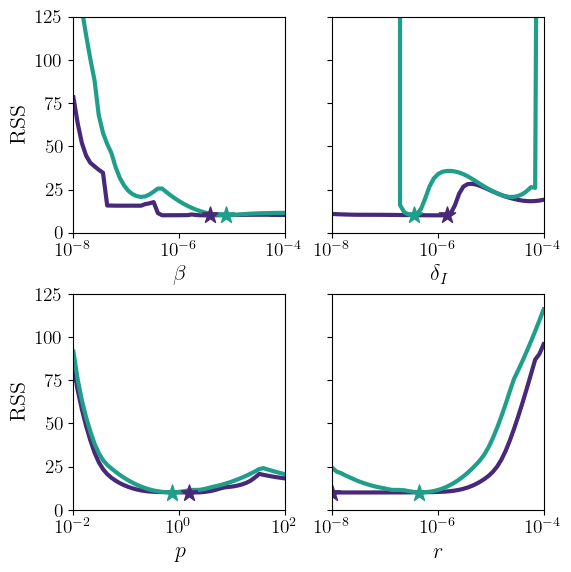

In [43]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6,6), facecolor='white', sharey=True)

axs[0,0].plot(10**df_bet_qt['$\\beta$'], df_bet_qt['RSS'], lw=3, color=palette[0])
axs[0,0].plot(10**df_bet_ql['$\\beta$'], df_bet_ql['RSS'], lw=3, color=palette[4])
axs[0,0].scatter(dfParam_describe_qt.median()['$\\beta$'], 10, color=palette[0],
                 marker='*', s=150, zorder=2)
axs[0,0].scatter(dfParam_describe_ql.median()['$\\beta$'], 10, color=palette[4],
                 marker='*', s=150, zorder=2)
# axs[0,0].set_xscale('log')
axs[0,0].set_xlabel('$\\beta$')
axs[0,0].set_ylabel('RSS')
axs[0,0].set_xlim((1e-8,1e-4))

axs[0,1].plot(10**df_delI_qt['$\\delta_I$'], df_delI_qt['RSS'], lw=3, color=palette[0])
axs[0,1].plot(10**df_delI_ql['$\\delta_I$'], df_delI_ql['RSS'], lw=3, color=palette[4])
axs[0,1].scatter(dfParam_describe_qt.median()['$\\delta_I$'], 10, color=palette[0],
                 marker='*', s=150, zorder=2)
axs[0,1].scatter(dfParam_describe_ql.median()['$\\delta_I$'], 10, color=palette[4],
                 marker='*', s=150, zorder=2)
axs[0,1].set_xlabel('$\\delta_I$')
axs[0,1].set_xlim((1e-8,1e-4))

axs[1,0].plot(10**df_p_qt['$p$'], df_p_qt['RSS'], lw=3, color=palette[0])
axs[1,0].plot(10**df_p_ql['$p$'], df_p_ql['RSS'], lw=3, color=palette[4])
axs[1,0].scatter(dfParam_describe_qt.median()['$p$'], 10, color=palette[0],
                 marker='*', s=150, zorder=2)
axs[1,0].scatter(dfParam_describe_ql.median()['$p$'], 10, color=palette[4],
                 marker='*', s=150, zorder=2)
axs[1,0].set_xlabel('$p$')
axs[1,0].set_ylabel('RSS')
axs[1,0].set_xlim((1e-2,1e2))

axs[1,1].plot(10**df_r_qt['$r$'], df_r_qt['RSS'], lw=3, color=palette[0])
axs[1,1].plot(10**df_r_ql['$r$'], df_r_ql['RSS'], lw=3, color=palette[4])
axs[1,1].scatter(dfParam_describe_qt.median()['$r$'], 10, color=palette[0],
                 marker='*', s=150, zorder=2)
axs[1,1].scatter(dfParam_describe_ql.median()['$r$'], 10, color=palette[4],
                 marker='*', s=150, zorder=2)
axs[1,1].set_xlabel('$r$')
axs[1,1].set_xlim((1e-8,1e-4))

for i in range(2):
    for j in range(2):
        axs[i,j].set_xscale('log')
plt.setp(axs, ylim=(0,125))

plt.tight_layout(w_pad=0.5, h_pad=0.1)
# plt.savefig("influenza_profiles_fix.svg", transparent=True)

plt.show()